<a href="https://colab.research.google.com/github/gbwiersum/CLApartmentScraper/blob/main/CLScraper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#!apt update
#!apt upgrade
!pip install selenium -q
!apt install chromium-chromedriver -y -q
import requests
from bs4 import BeautifulSoup
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
import datetime
import re

Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  chromium-browser chromium-browser-l10n chromium-codecs-ffmpeg-extra
Suggested packages:
  webaccounts-chromium-extension unity-chromium-extension
The following NEW packages will be installed:
  chromium-browser chromium-browser-l10n chromium-chromedriver
  chromium-codecs-ffmpeg-extra
0 upgraded, 4 newly installed, 0 to remove and 5 not upgraded.
Need to get 93.9 MB/95.1 MB of archives.
After this operation, 319 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-browser amd64 107.0.5304.87-0ubuntu11.18.04.1 [83.1 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-browser-l10n all 107.0.5304.87-0ubuntu11.18.04.1 [5,260 kB

Defining basic methods,
Building the scraping engine. 


1.   Gets each page of listings
2.   For each page of listings, gets attributes and headline descriptions, sqft, rent and a url for the posting.



In [6]:
# Open a browser instance.
def start_browser(headless = True):
  chrome_options = webdriver.ChromeOptions()
  if headless:
    chrome_options.add_argument('--headless')
  chrome_options.add_argument('--no-sandbox')
  chrome_options.add_argument('--disable-dev-shm-usage')
  webbrowser = webdriver.Chrome('chromedriver', options=chrome_options)
  if not headless:
    webbrowser.set_window_size(48, 32)
  return webbrowser


#Starts searching at a predefined URL
#Increments search for "results" number of pages, -1 for "all"
#Listings are iterated over and attributes are put into a dictionary
def get_listings(start_url, results=-1, cooldown=0):
  browser=start_browser()
  browser.get(start_url)
  result_dict = {}
  if results == -1:
    end = int(BeautifulSoup(browser.page_source).find('span', class_='totalcount').text)
  else:
    end = min([int(BeautifulSoup(browser.page_source).find('span', class_='totalcount').text), results])

  for n in range(0, end, 120):
      if n>0:
        browser.get((start_url+'?s='+str(n)))
      else:
        time.sleep(cooldown)
        browser.get(start_url)

      #Debug:
      #pagestart = BeautifulSoup(browser.page_source).find('span', class_='rangeFrom').text
      #pageend = BeautifulSoup(browser.page_source).find('span', class_='rangeTo').text
      #print("Processing: "+pagestart+" through " + pageend)
      #####

      listings = browser.find_elements(by=By.CLASS_NAME, value='result-info')
      for l in listings:
        html = l.get_attribute('innerHTML')
        attributes = get_listing_attributes(html)
        result_dict.update(attributes)

  final = pd.DataFrame.from_dict(result_dict, orient = 'index')
  final.columns = ['heading', 'url', 'rent', 'date posted', 'beds', 'sqft']
  return(final)

#Rewriting results page into dictionary format
#Takes html string of individual search result, returns dictionary with CL unique ID as index.
def get_listing_attributes(html):
    url = BeautifulSoup(html).a.get('href')

    try:
      price = BeautifulSoup(html).find('span', class_="result-price").text
      price = price.replace("$", "").replace(",", "")
      price = int(price)
    except:
      price = None
    
    date = BeautifulSoup(html).find('time', class_="result-date").get('datetime')

    try:
      bed = xml_getter(BeautifulSoup(html).find('span', class_="housing").text, after='br')
      bed = int(bed)
    except:
      bed=0

    try:
        sqft = xml_getter(BeautifulSoup(html).find('span', class_="housing").text, before="", after="ft2")
        sqft = int(sqft)
    except:
        sqft=None

    heading = BeautifulSoup(html).find('a', class_="result-title hdrlnk").text
    id = BeautifulSoup(html).find('a', class_='result-title hdrlnk').get('data-id')

    return({id:[heading, url, price, date, bed, sqft]})


#utility to pull variables out of xml data using leading and following tag.
#I refusue to learn regex and this is my workaround for that.
def xml_getter(text, before="", after=""):
  m = re.search(before+'(.+?)'+after, text)
  if m:
      found = m.group(1).strip()
      return(found)


#Scraping Results Page:

In [7]:
listingdf = get_listings('https://chicago.craigslist.org/search/apa', results=-1, cooldown=2)

In [8]:
browser = start_browser()
def pull_html(url, cooldown=0):
  try:
    browser.get(url)
    html = BeautifulSoup(browser.page_source)
    if html.header is None:
      return None
    elif 'blocked' in html:
      return None
    elif 'Page Not Found' in html.text:
      return "invalid url"
    else:
      time.sleep(cooldown)
      return html
  except:
    return None


def fetch_blank_listings(listingdf):
  #browser = start_browser()
  browser.get(listingdf['url'][0])
  tester = browser.page_source
  if len(tester)>1000:
    nans = listingdf[listingdf['html'].isna()]['url'].apply(lambda x: pull_html(x, cooldown=2))
    return(nans)
  else:
    print("failed to fetch first listing")
    print(BeautifulSoup(browser.page_source))

In [9]:
#Cleaning up listings that are improbably cheap or expensive
listingdf = listingdf[listingdf['rent']<10000]
listingdf = listingdf[listingdf['rent']>100]

# Analysis of Search Results:

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


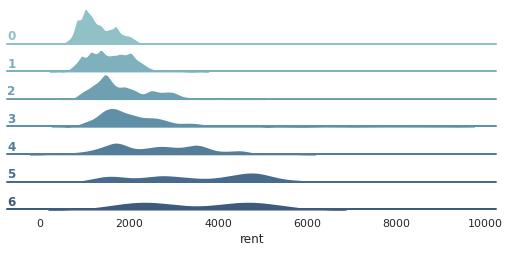

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(listingdf, row="beds", hue="beds", aspect=15, height=.5, palette=pal)
g.map(sns.kdeplot, "rent",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)

g.map(sns.kdeplot, "rent", clip_on=False, color="w", lw=2, bw_adjust=.5)

g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "rent")
g.figure.subplots_adjust(hspace=-.25)
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

1.1404*X+645.6436
r=0.6292
p=0.0


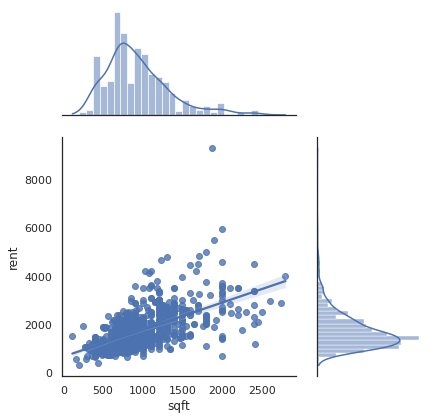

In [11]:
from scipy.stats import linregress
model = listingdf[listingdf['sqft']<3000]
f = sns.jointplot(x=model['sqft'], 
              y=model['rent'], 
              #hue = model['beds'],
              ratio=2,
              kind='reg',
              )

slope, intercept, r, p, se = linregress(x=listingdf[listingdf['sqft']>0]['sqft'], y=listingdf[listingdf['sqft']>0]['rent'])
print(str(slope.round(4))+"*X+"+str(intercept.round(4))+"\nr="+str(r.round(4))+"\np="+str(p.round(4)))

R^2 Score: 0.3743
Coefs: [-67.06454814   1.24268436]
Standard Error: 608.6475


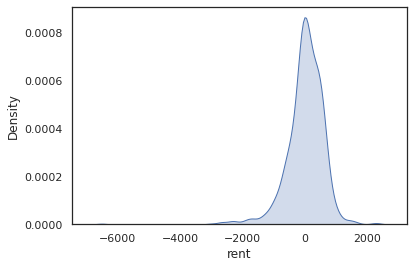

In [12]:
from sklearn import linear_model
y = model['rent']
x = model[['beds', 'sqft']]
multi_model = linear_model.LinearRegression()
multi_model.fit(x,y)
sns.kdeplot(multi_model.predict(x)-y, shade=True)
print('R^2 Score: '+str(multi_model.score(x,y).round(4)))
print("Coefs: "+str(multi_model.coef_))
print("Standard Error: "+str((multi_model.predict(x)-y).std().round(4)))

R^2 Score: 0.3713
Coefs: [1.11708152]
Standard Error: 610.1165


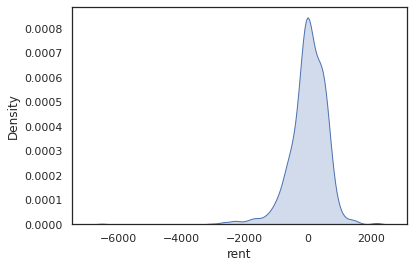

In [13]:
y = model['rent']
x = model[['sqft']]
multi_model = linear_model.LinearRegression()
multi_model.fit(x,y)
sns.kdeplot(multi_model.predict(x)-y, shade=True)
print('R^2 Score: '+str(multi_model.score(x,y).round(4)))
print("Coefs: "+str(multi_model.coef_))
print("Standard Error: "+str((multi_model.predict(x)-y).std().round(4)))

Number of bedrooms is not a significant factor over square-footage. Knowing the number of beds does not improve predictions of value, implying no meaningful relationship apart from communicating square-footage.

In [14]:
northside = get_listings('https://chicago.craigslist.org/search/chicago-il/apa?lat=41.9246&lon=-87.6801&search_distance=2.6')
southside = get_listings("https://chicago.craigslist.org/search/chicago-il/apa?lat=41.8128&lon=-87.6664&search_distance=4.3")
model['side']='S'
model = southside[['rent', 'beds', 'sqft']]
model['side']="S"
model = model.append(northside[['rent', 'beds', 'sqft']])
model['side'].fillna("N", inplace = True)
model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,rent,beds,sqft,side
7558083902,2999,2,1130.0,S
7558076291,1515,1,NaN,S
7558074803,1695,2,NaN,S
7558045772,1015,2,950.0,S
7558045377,1600,5,NaN,S
...,...,...,...,...
7557308882,2625,2,NaN,N
7557766975,1600,1,NaN,N
7557810347,1180,0,NaN,N
7558085319,1297,1,NaN,N


In [15]:
model[model['side']=='S']['rent'].describe()

count     122.000000
mean     1640.311475
std       650.700158
min       400.000000
25%      1200.000000
50%      1455.000000
75%      2007.500000
max      4348.000000
Name: rent, dtype: float64

In [16]:
model[model['side']=='N']['rent'].describe()

count     124.000000
mean     1939.766129
std       765.114945
min       695.000000
25%      1398.750000
50%      1786.500000
75%      2213.250000
max      4850.000000
Name: rent, dtype: float64

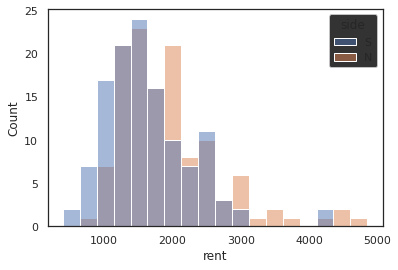

In [17]:
sns.histplot(model, x='rent', hue='side')

In [18]:
model['rent']=model['rent'].map(int)
model['ppsf'] = model['rent']/model['sqft']


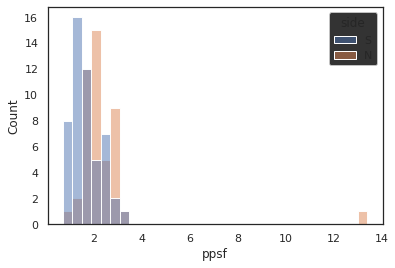

In [19]:
sns.histplot(model, x='ppsf', hue='side')

In [20]:
#Fill in the blanks:
def fetch_blank_listings(listingdf):
  browser = start_browser()
  browser.get(listingdf['url'][0])
  tester = browser.page_source
  if len(tester)>1000:
    nans = listingdf[listingdf['html'].isna()]['url'].apply(lambda x: pull_html(x, cooldown=2))
    return(nans)
  else:
    print("failed to fetch first listing")
    print(BeautifulSoup(browser.page_source))

In [21]:
#Pull listings html:
listingdf['html']=listingdf['url'][0:100].apply(lambda x: pull_html(x, cooldown=5))

In [22]:
def parse_listing_html(page_source):
  text=None
  attrvals = []
  if page_source is not None:
    try:
      text = str(page_source.find_all('p', class_='attrgroup')[0])
    except:
      text = None

  if text is not None:
    #baths, description body
    bedbath = BeautifulSoup(text).find('span', class_='shared-line-bubble').text
    baths = xml_getter(bedbath, before="/ ", after='Ba')
    body = str(page_source.find('section', id='postingbody').text).strip()

    try:
      #Latitude and longitude
      map_data = str(page_source.find_all('div', id='map')[0])
      lat = xml_getter(map_data, before='data-latitude="', after='" ')
      lon = xml_getter(map_data, before='data-longitude="', after='" ')
    except IndexError:
      lat=None
      lon=None
    attrvals.extend([baths,body,lat,lon])

    #Dogs/cats allowed, laundry situation:
    attrtext = page_source.find_all("p", class_='attrgroup')[1].text

    #We need to use a regex to pull the specific attributes
    park = re.search('\n(.+?)'+"park"+'(.+?)\n', attrtext)
    dog = re.search('\n'+'dog'+'(.+?)\n', attrtext)
    cat = re.search('\n'+'cat'+'(.+?)\n', attrtext)
    laundry = re.search('\n'+'laundry'+'(.+?)\n', attrtext)

    #Then we can pull them each out and add them to our list:
    attrs = [park, dog, cat, laundry]
    for n in attrs:
      if n is None:
        attrvals.append('None')
      else:
        attrvals.append(n.group(0).strip())

    return attrvals

  else:
    return None

#columns = ['baths', 'body', 'lat', 'lon', 'parking', 'dogs', 'cats', 'laundry']

In [23]:

parsed = listingdf.apply(lambda x: parse_listing_html(x['html']), axis='columns', result_type='expand')
parsed.columns = ['baths', 'body', 'lat', 'lon', 'parking', 'dogs', 'cats', 'laundry']
listingdf = listingdf.join(parsed)
listingdf['Dpsf']=listingdf['rent']/listingdf['sqft']

def clean(heading):
  heading = heading.replace('QR Code Link to This Post\n\n\n', "")
  heading = heading.replace("\n", "")
  heading = re.sub('[^0-9a-zA-Z]+', " ", heading)
  heading = heading.lower()
  return(heading)

  listingdf['heading'].map(clean)

listingdf

,heading,url,rent,date posted,beds,sqft,html,baths,body,lat,lon,parking,dogs,cats,laundry,Dpsf
7558079379,"Upgraded 2 bed / 2 bath! Character, style, and...",https://chicago.craigslist.org/nwc/apa/d/arlin...,1620,2022-11-16 09:40,2,924.0,"[[[\n, <meta charset=""utf-8""/>, \n, <meta cont...",2,QR Code Link to This Post\n\n\nResidences at A...,42.047076,-87.974769,street parking,dogs are OK - wooof,cats are OK - purrr,laundry on site,1.753247
7558079341,AMAZING BRAND NEW LUXURY STUDIO IN RED HOT WES...,https://chicago.craigslist.org/chc/apa/d/chica...,1900,2022-11-16 09:40,0,500.0,"[[[\n, <meta charset=""utf-8""/>, \n, <meta cont...",1,QR Code Link to This Post\n\n\nPROPERTY INFO\n...,41.883701,-87.652380,None,dogs are OK - wooof,cats are OK - purrr,None,3.800000
7558078263,In Unit Laundry! Hot Lincoln Park Location!,https://chicago.craigslist.org/chc/apa/d/chica...,2889,2022-11-16 09:37,2,NaN,"[[[\n, <meta charset=""utf-8""/>, \n, <meta cont...",2,QR Code Link to This Post\n\n\nCall Apartment ...,41.930832,-87.644054,off-street parking,dogs are OK - wooof,cats are OK - purrr,None,NaN
7558077920,Beautiful One Bedrooms (Chicago-West Pullman ),https://chicago.craigslist.org/chc/apa/d/chica...,950,2022-11-16 09:36,1,NaN,"[[[\n, <meta charset=""utf-8""/>, \n, <meta cont...",1,QR Code Link to This Post\n\n\n11941 S Parnell...,41.677158,-87.635865,street parking,None,None,None,NaN
7558077715,Live right on the Lakeview and Lincoln Park Bo...,https://chicago.craigslist.org/chc/apa/d/chica...,2290,2022-11-16 09:36,3,NaN,"[[[\n, <meta charset=""utf-8""/>, \n, <meta cont...",1,QR Code Link to This Post\n\n\nCall Apartment ...,41.932832,-87.646854,street parking,dogs are OK - wooof,cats are OK - purrr,laundry in bldg,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7551945752,"Spacious studio with 24hr doorman & huge gym, ...",https://chicago.craigslist.org/chc/apa/d/chica...,1405,2022-10-31 07:55,0,NaN,NaN,None,None,None,None,None,None,None,None,NaN
7551945571,Beautiful 2bed in River North with w/d in unit...,https://chicago.craigslist.org/chc/apa/d/chica...,3020,2022-10-31 07:54,2,NaN,NaN,None,None,None,None,None,None,None,None,NaN
7551945451,"658 W. Aldine Ave Unit 2 in/unit W/D, HVAC & D...",https://chicago.craigslist.org/chc/apa/d/chica...,3350,2022-10-31 07:53,3,2000.0,NaN,None,None,None,None,None,None,None,None,1.675000
7551945362,"Great unit in River North w ss appli, wd, walk...",https://chicago.craigslist.org/chc/apa/d/chica...,2050,2022-10-31 07:53,1,NaN,NaN,None,None,None,None,None,None,None,None,NaN


In [24]:
listingdf.dropna()

,heading,url,rent,date posted,beds,sqft,html,baths,body,lat,lon,parking,dogs,cats,laundry,Dpsf
7558079379,"Upgraded 2 bed / 2 bath! Character, style, and...",https://chicago.craigslist.org/nwc/apa/d/arlin...,1620,2022-11-16 09:40,2,924.0,"[[[\n, <meta charset=""utf-8""/>, \n, <meta cont...",2,QR Code Link to This Post\n\n\nResidences at A...,42.047076,-87.974769,street parking,dogs are OK - wooof,cats are OK - purrr,laundry on site,1.753247
7558079341,AMAZING BRAND NEW LUXURY STUDIO IN RED HOT WES...,https://chicago.craigslist.org/chc/apa/d/chica...,1900,2022-11-16 09:40,0,500.0,"[[[\n, <meta charset=""utf-8""/>, \n, <meta cont...",1,QR Code Link to This Post\n\n\nPROPERTY INFO\n...,41.883701,-87.652380,None,dogs are OK - wooof,cats are OK - purrr,None,3.800000
7558067387,Modern Converted Firehouse 2 Bedroom & 2 Bathr...,https://chicago.craigslist.org/chc/apa/d/chica...,2300,2022-11-16 09:13,2,1000.0,"[[[\n, <meta charset=""utf-8""/>, \n, <meta cont...",2,QR Code Link to This Post\n\n\nPROPERTY INFO\n...,41.970532,-87.659855,off-street parking,None,None,None,2.300000
7558064390,🗣️ARLINGTON HEIGHTS🗣️ 1-2BR APARTMENTS AVAILAB...,https://chicago.craigslist.org/nwc/apa/d/arlin...,1450,2022-11-16 09:06,2,725.0,"[[[\n, <meta charset=""utf-8""/>, \n, <meta cont...",1,QR Code Link to This Post\n\n\nNew Location No...,42.082227,-87.970470,off-street parking,dogs are OK - wooof,cats are OK - purrr,laundry on site,2.000000
7558063290,🛀WELCOME HOME🛌2 BED w/ HEAT INCLUDED SEC 8 OK,https://chicago.craigslist.org/sox/apa/d/calum...,1380,2022-11-16 09:04,2,835.0,"[[[\n, <meta charset=""utf-8""/>, \n, <meta cont...",1,QR Code Link to This Post\n\n\nID: c0634sib\n\...,41.622735,-87.539633,off-street parking,dogs are OK - wooof,cats are OK - purrr,laundry on site,1.652695
7558060692,2 Bedroom Apartment for rent at 705 Napoleon S...,https://chicago.craigslist.org/nwi/apa/d/valpa...,1100,2022-11-16 08:58,2,900.0,"[[[\n, <meta charset=""utf-8""/>, \n, <meta cont...",1,QR Code Link to This Post\n\n\nRecently Remode...,41.454700,-87.065600,off-street parking,dogs are OK - wooof,cats are OK - purrr,laundry on site,1.222222
7558050600,"Spacious 3 bed 1 bath, open family to living r...",https://chicago.craigslist.org/chc/apa/d/chica...,2150,2022-11-16 08:31,3,1250.0,"[[[\n, <meta charset=""utf-8""/>, \n, <meta cont...",1,QR Code Link to This Post\n\n\nJust finished r...,41.946400,-87.704200,street parking,None,cats are OK - purrr,laundry in bldg,1.720000
7558049455,"📚SOUTH SHORE 2BD w/ HIGH-END FINISHES, HEAT, D...",https://chicago.craigslist.org/chc/apa/d/chica...,1070,2022-11-16 08:29,2,750.0,"[[[\n, <meta charset=""utf-8""/>, \n, <meta cont...",1,QR Code Link to This Post\n\n\nID: c7700kin\n\...,41.755397,-87.562644,street parking,dogs are OK - wooof,cats are OK - purrr,laundry on site,1.426667
7558049195,"Fabulous 1 Bedroom, 1 Bath in Lakeview, Availa...",https://chicago.craigslist.org/chc/apa/d/chica...,1595,2022-11-16 08:28,1,700.0,"[[[\n, <meta charset=""utf-8""/>, \n, <meta cont...",1,QR Code Link to This Post\n\n\nLakeview\n1 Bed...,41.939900,-87.652800,off-street parking,dogs are OK - wooof,cats are OK - purrr,laundry in bldg,2.278571
7558048043,"Priceless 1 Bedroom, 1 Bath in Ravenswood, Ava...",https://chicago.craigslist.org/chc/apa/d/chica...,1495,2022-11-16 08:25,1,700.0,"[[[\n, <meta charset=""utf-8""/>, \n, <meta cont...",1,QR Code Link to This Post\n\n\nRavenswood\n1 B...,41.970300,-87.704200,street parking,dogs are OK - wooof,cats are OK - purrr,laundry in bldg,2.135714


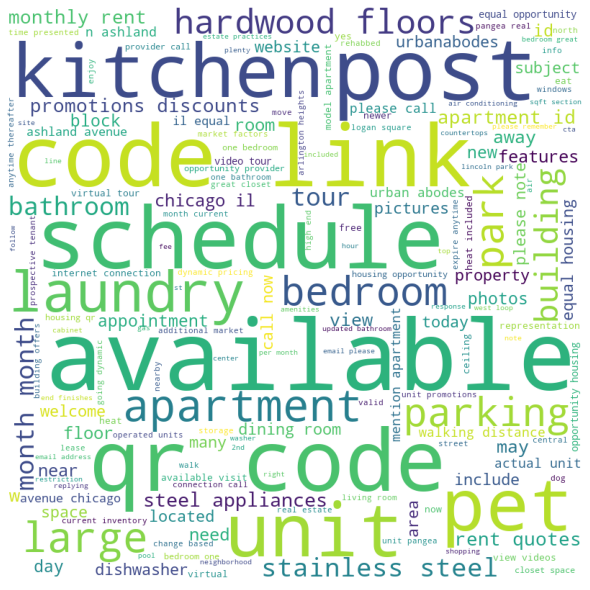

In [25]:
# importing all necessary modules
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
 
comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in listingdf.dropna().body:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

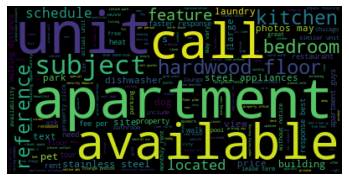

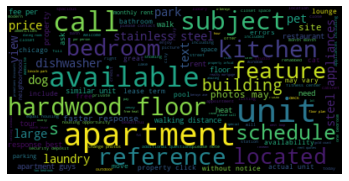

In [27]:
text = " ".join(clean(str(i)) for i in listingdf['body'].dropna())
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [28]:
#df=pd.read_csv('./CLScraped.csv')
dummy = listingdf[['rent','sqft', 'beds', 'baths', 'parking', 'lat', 'lon', 'dogs', 'cats', 'laundry']].dropna()
dummy['rent'] = dummy['rent'].apply(lambda x: (x-min(dummy['rent']))/(max(dummy['rent'])))
dummy['beds']=dummy['beds']/max(dummy['beds'])
dummy['dogs'].replace("None", 0, inplace=True)
dummy['dogs'].replace("dogs are OK - wooof", 1, inplace=True)
dummy['cats'].replace("None", 0, inplace=True)
dummy['cats'].replace('cats are OK - purrr', 1, inplace = True)
dummy['laundry'].replace('laundry in bldg', 1, inplace=True)
dummy["laundry"].replace('laundry on site', 1, inplace=True)
dummy['laundry'].replace("None", 0, inplace=True)
dummy[dummy['parking'].notnull()]['parking']=1
dummy['parking'].fillna(0, inplace=True)
dummy['sqft'].replace(0, None)
dummy['lat'] = dummy['lat'].map(float)
dummy['lon'] = dummy['lon'].map(float)
#########delete this later
dummy['baths']=dummy['baths'].apply(lambda x: float(x))
#########

dummy['baths']=dummy['baths']/max(dummy['baths'])

dummy = dummy.drop(columns=['sqft', 'parking'])